In [1]:
import os
print(os.getcwd())  # Affiche le répertoire courant


c:\Users\jcluy\Python\detection-anomalies-aws-mlflow\notebooks


In [2]:
import os

# Changer de répertoire
os.chdir("C:/Users/jcluy/Python/detection-anomalies-aws-mlflow")

# Vérifier qu'on est bien dans le bon dossier
print("Répertoire actuel :", os.getcwd())

Répertoire actuel : C:\Users\jcluy\Python\detection-anomalies-aws-mlflow


In [3]:
from src.FonctionsPerso import *
import pandas as pd

# Définir le chemin proprement
base_dir = "C:/Users/jcluy/Python/detection-anomalies-aws-mlflow"
file_path = os.path.join(base_dir, "data", "raw", "creditcard.csv")

# Charger les données
df = pd.read_csv(file_path, sep=',')

# Vérifier le chargement
print(df.head())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

----------------------------------------------------------------------------------------------------
                               Informations sur le jeu de données
----------------------------------------------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14    

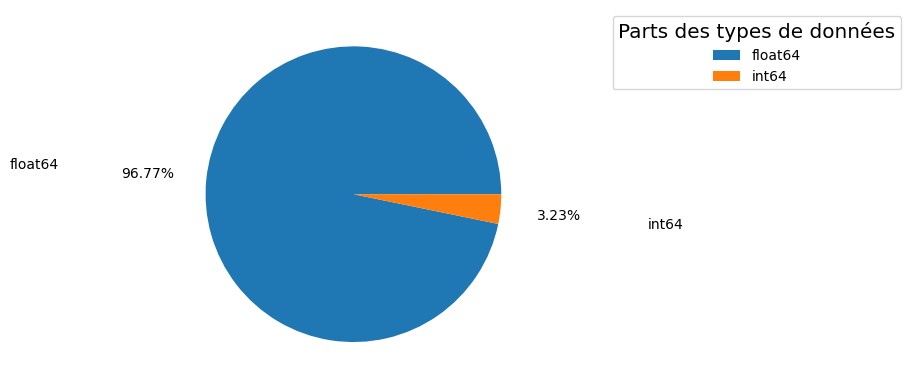

  
----------------------------------------------------------------------------------------------------


,Nombre de valeurs manquantes,Nombre de valeurs présentes,Taux de remplissage,Nombre de valeurs uniques,Doublons
Time,0,284807,100.0,124592,160215
V1,0,284807,100.0,275663,9144
V2,0,284807,100.0,275663,9144
V3,0,284807,100.0,275663,9144
V4,0,284807,100.0,275663,9144
V5,0,284807,100.0,275663,9144
V6,0,284807,100.0,275663,9144
V7,0,284807,100.0,275663,9144
V8,0,284807,100.0,275663,9144
V9,0,284807,100.0,275663,9144


In [4]:
afficher_informations_dataset(df)

In [5]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
# Vérifier les valeurs manquantes
missing_values = df.isnull().sum()
missing_values[missing_values > 0]  # Affiche uniquement les colonnes avec des NaN


Series([], dtype: int64)

In [7]:
# Vérifier les doublons
duplicates = df.duplicated().sum()
print(f"Nombre de doublons : {duplicates}")

# Supprimer les doublons si nécessaire
df = df.drop_duplicates()


Nombre de doublons : 1081


In [8]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


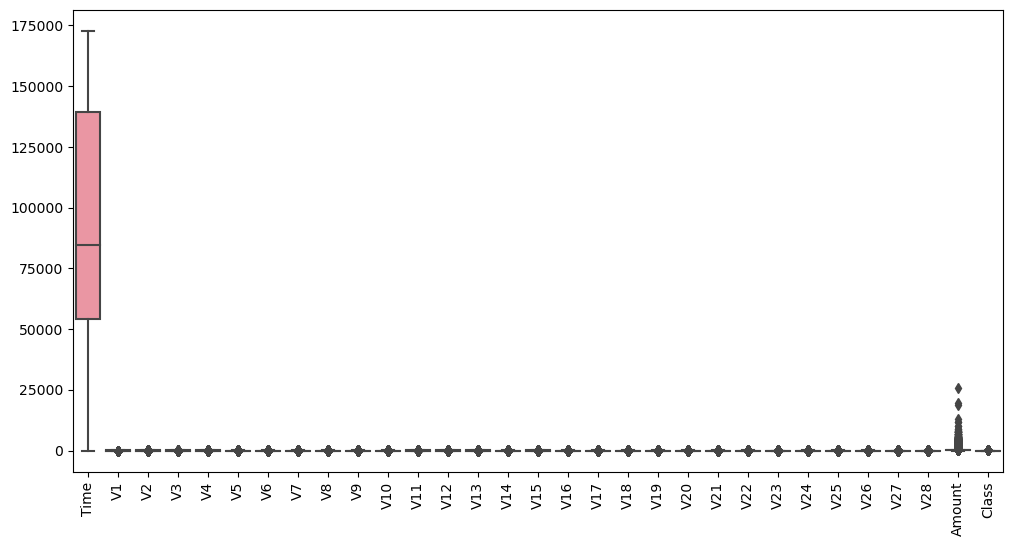

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [11]:
df_scaled

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996823,-0.701082,-0.041687,1.680101,0.976623,-0.247020,0.348012,0.193700,0.084434,0.333534,...,-0.024777,0.383483,-0.177444,0.110157,0.247059,-0.392622,0.333033,-0.065850,0.244200,-0.040864
1,-1.996823,0.608792,0.164138,0.109279,0.318998,0.042258,-0.060980,-0.065656,0.072903,-0.231703,...,-0.311372,-0.881454,0.162081,-0.561503,0.321175,0.260854,-0.027154,0.043219,-0.342584,-0.040864
2,-1.996802,-0.700336,-0.811337,1.174270,0.270648,-0.366756,1.352655,0.643223,0.210788,-1.381169,...,0.343094,1.065068,1.457772,-1.138484,-0.628161,-0.288861,-0.144325,-0.183824,1.158900,-0.040864
3,-1.996802,-0.499064,-0.109972,1.187383,-0.608355,-0.008814,0.937245,0.192079,0.320843,-1.264664,...,-0.149093,0.007299,-0.305465,-1.941446,1.242487,-0.460694,0.154039,0.185687,0.139886,-0.040864
4,-1.996781,-0.597606,0.535539,1.025470,0.287092,-0.297036,0.072873,0.481517,-0.228725,0.747917,...,-0.012516,1.101780,-0.220709,0.232904,-0.394800,1.041677,0.550001,0.654234,-0.073813,-0.040864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283721,1.642235,-6.102103,6.118855,-6.519873,-1.459282,-3.897079,-1.956335,-4.007632,6.196662,1.749010,...,0.295375,0.154412,1.626230,-0.841382,2.757072,0.518377,2.380049,2.509507,-0.350252,-0.040864
283722,1.642257,-0.379208,-0.030938,1.347812,-0.520175,0.629193,0.795504,0.018351,0.250814,0.535282,...,0.296413,1.275826,0.019665,-1.678330,-1.163409,-0.820253,0.168567,-0.164849,-0.254325,-0.040864
283723,1.642278,0.982354,-0.180433,-2.155033,-0.392355,1.908988,2.276699,-0.243249,0.601561,0.396215,...,0.321057,0.798074,-0.060444,1.056626,0.510299,-0.181557,0.006802,-0.082640,-0.082239,-0.040864
283724,1.642278,-0.126465,0.324660,0.464577,0.489870,-0.275808,0.469130,-0.560399,0.576734,0.359367,...,0.366919,1.104223,-0.262138,0.203081,-1.091530,1.133734,0.270523,0.317004,-0.313391,-0.040864


In [12]:
df.to_csv("data/processed/creditcard_cleaned.csv", index=False)

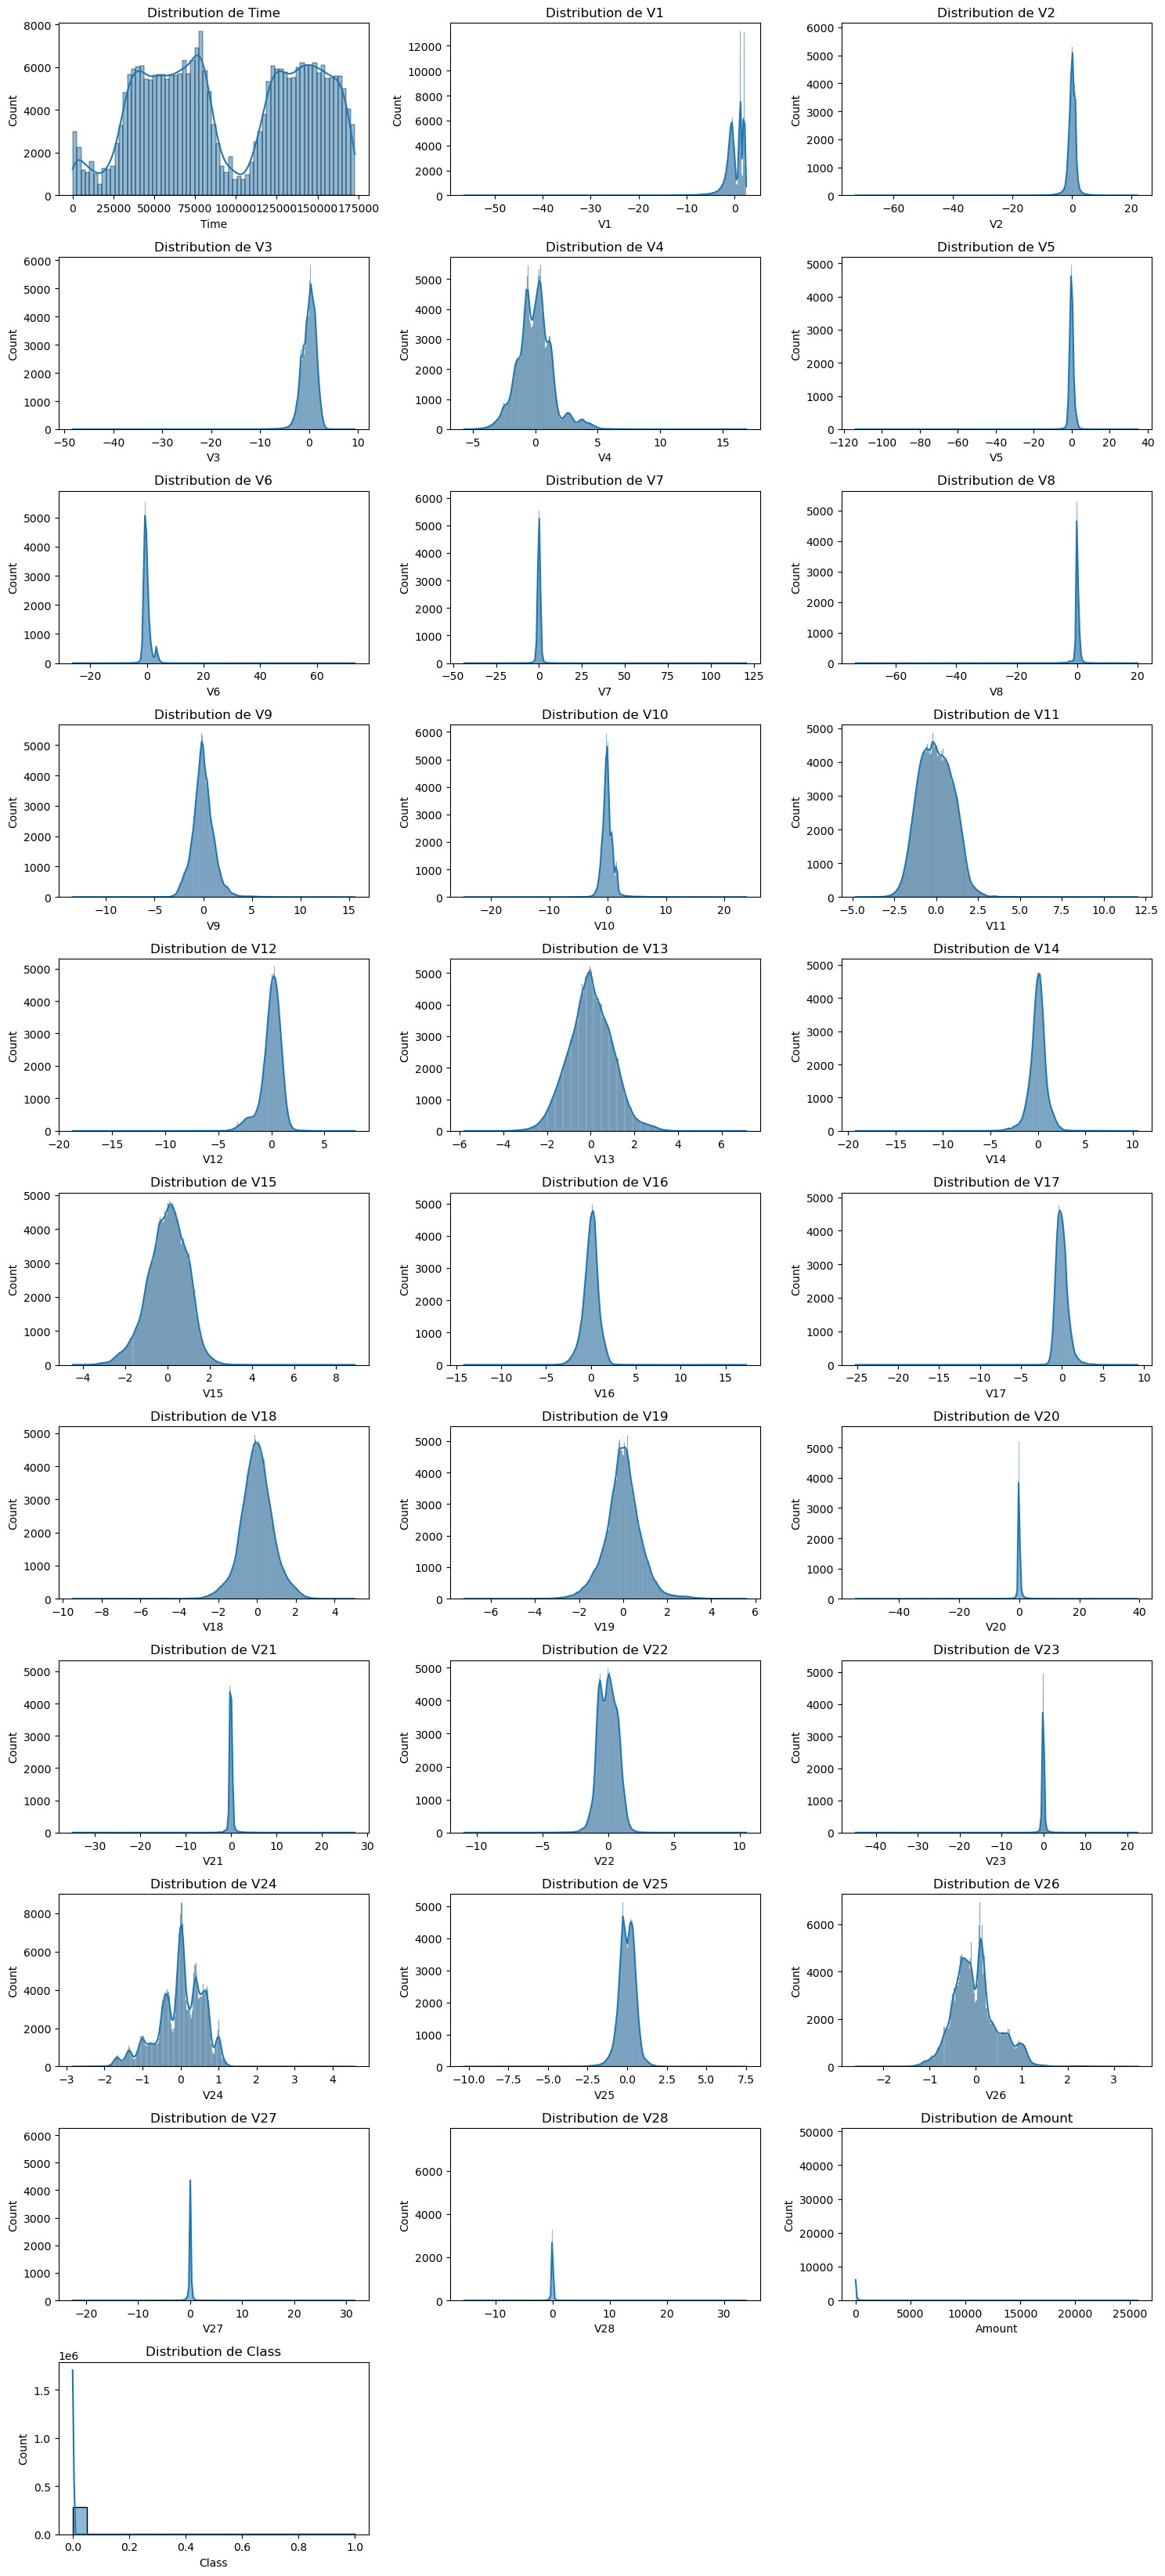

In [13]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Sélectionner les colonnes numériques (hors labels comme 'Class' si présent)
num_cols = df.select_dtypes(include=[np.number]).columns

# Déterminer le nombre de lignes et colonnes pour les subplots
n_cols = 3  # Fixe le nombre de colonnes à 3
n_rows = int(np.ceil(len(num_cols) / n_cols))  # Calcule dynamiquement le nombre de lignes

# Créer les subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3)) 
axes = axes.flatten()  # Aplatir la grille en 1D pour éviter les erreurs d'index

# Boucle pour tracer les histogrammes
for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution de {col}")

# Supprimer les subplots inutilisés s'il y en a
for j in range(i + 1, len(axes)):  
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

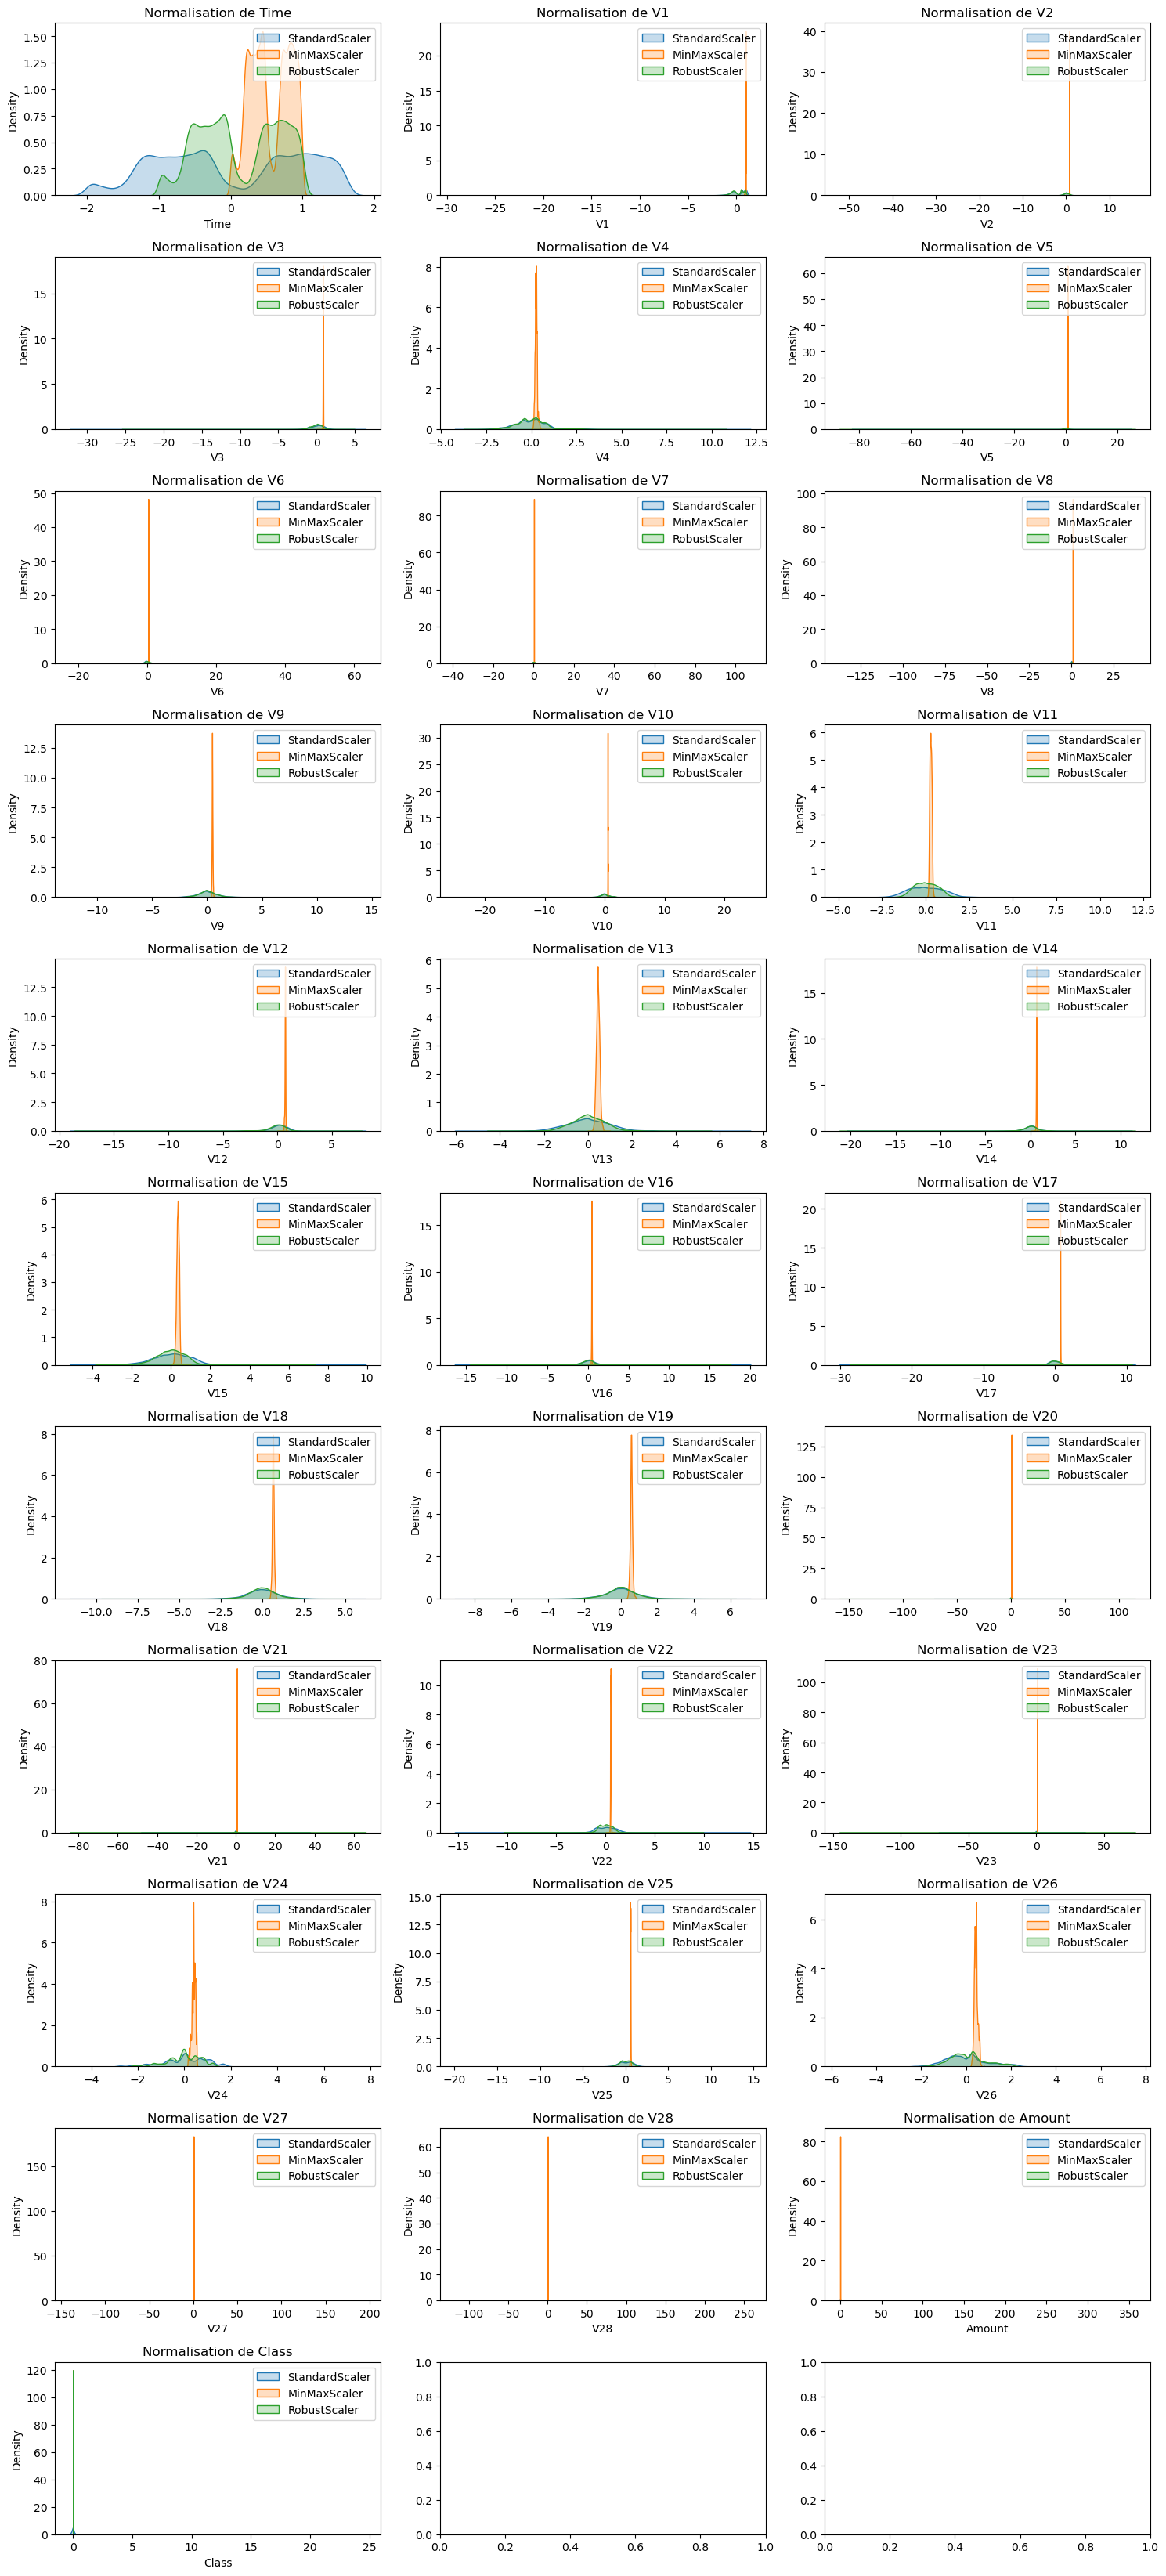

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

scaled_dfs = {}

# Déterminer le nombre de lignes et colonnes pour les subplots
n_cols = 3  # Fixe le nombre de colonnes à 3
n_rows = int(np.ceil(len(num_cols) / n_cols))  # Calcule dynamiquement le nombre de lignes

for name, scaler in scalers.items():
    scaled_df = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols)
    scaled_dfs[name] = scaled_df

# Créer les subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3)) 
axes = axes.flatten()  # Aplatir la grille en 1D pour éviter les erreurs d'index

for i, col in enumerate(num_cols):
    for name, scaled_df in scaled_dfs.items():
        sns.kdeplot(scaled_df[col], ax=axes[i], label=name, fill=True)
    axes[i].set_title(f"Normalisation de {col}")
    axes[i].legend()

plt.tight_layout()
plt.show()


Variance expliquée par les deux premières composantes : 0.12


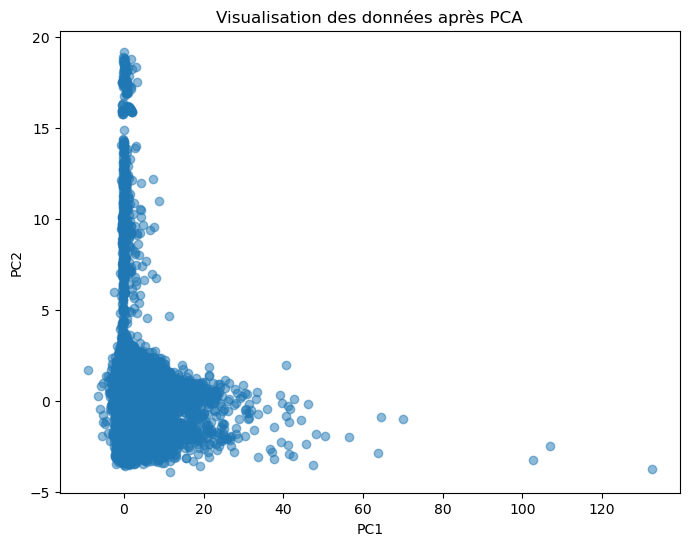

In [15]:
from sklearn.decomposition import PCA

# Appliquer PCA sur les données normalisées
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(scaled_dfs["StandardScaler"])  # Changer pour tester d'autres scalers

# Visualiser la variance expliquée
print(f"Variance expliquée par les deux premières composantes : {sum(pca.explained_variance_ratio_):.2f}")

# Visualisation du PCA
plt.figure(figsize=(8,6))
plt.scatter(pca_transformed[:,0], pca_transformed[:,1], alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Visualisation des données après PCA")
plt.show()


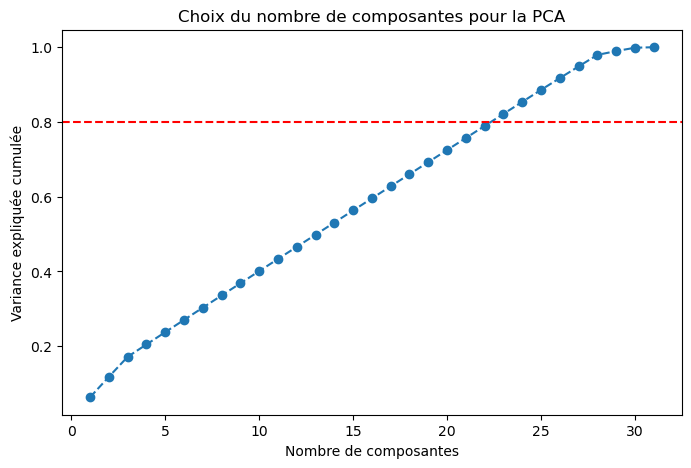

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca_full = PCA()
pca_full.fit(scaled_dfs["StandardScaler"])  # Changer pour tester un autre scaler

# Calculer la variance expliquée cumulée
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Tracer le graphe
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.8, color='r', linestyle='--')  # Ligne rouge pour 80% de variance expliquée
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée cumulée")
plt.title("Choix du nombre de composantes pour la PCA")
plt.show()


In [17]:
feature_importance = np.abs(pca_full.components_[0])
feature_names = scaled_dfs["StandardScaler"].columns

# Afficher les features les plus importantes pour PC1
sorted_idx = np.argsort(feature_importance)[::-1]
for i in range(10):
    print(f"{feature_names[sorted_idx[i]]}: {feature_importance[sorted_idx[i]]:.3f}")


Amount: 0.705
V2: 0.389
V7: 0.293
V5: 0.291
V20: 0.252
V1: 0.174
V6: 0.159
V3: 0.147
V23: 0.083
V21: 0.080


In [18]:
# Vérifier les valeurs négatives par colonne
neg_values = df[num_cols].lt(-1).sum()
print(neg_values[neg_values > 0])  # Afficher uniquement les colonnes avec des valeurs < -1


V1     64810
V2     44727
V3     65644
V4     60684
V5     46100
V6     44163
V7     32855
V8     12288
V9     43609
V10    30556
V11    49476
V12    33198
V13    44396
V14    28505
V15    38024
V16    31037
V17    13269
V18    27031
V19    27567
V20     5356
V21     5361
V22    17907
V23     3714
V24    21350
V25     8756
V26     2959
V27     3988
V28     2145
dtype: int64


In [19]:
df_shifted = df.copy()

for col in num_cols:
    min_val = df_shifted[col].min()
    if min_val < 0:  
        df_shifted[col] += abs(min_val) + 1  # Décalage pour que la plus petite valeur soit 1

# Appliquer la transformation logarithmique après le décalage
df_log = np.log1p(df_shifted[num_cols])

In [20]:
df_log = df.copy()
for col in num_cols:
    df_log[col] = np.log1p(df_log[col])  # log(x + 1) pour éviter log(0)


c:\Users\jcluy\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [21]:
df_log.describe()  # Vérifier les statistiques après la transformation

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,218916.000000,238999.000000,218082.000000,223042.000000,237626.000000,239563.000000,250871.000000,271438.000000,240117.000000,...,278365.000000,265819.000000,280012.000000,262376.000000,274970.000000,280767.000000,279738.000000,281581.000000,283726.000000,283726.000000
mean,11.252577,0.180864,0.066551,0.219321,0.033915,-0.039992,-0.228206,-0.053412,0.032689,-0.040696,...,-0.041130,-0.172745,-0.030542,-0.062572,-0.089374,-0.119293,-0.011278,-0.012674,3.153760,0.001156
std,0.817511,1.087441,0.893207,0.888237,1.009686,0.966954,1.090305,0.866046,0.494495,0.914764,...,0.404123,0.882855,0.370111,0.738275,0.607333,0.581013,0.321750,0.260549,1.657080,0.028278
min,0.000000,-10.700273,-12.649645,-11.857790,-12.207498,-10.722657,-10.496727,-11.797391,-9.068753,-11.038931,...,-9.949870,-11.814369,-7.865492,-10.121010,-9.691099,-10.442300,-11.130226,-7.801248,0.000000,0.000000
25%,10.900542,-0.444459,-0.270191,-0.108863,-0.440298,-0.443607,-0.781723,-0.389923,-0.193032,-0.409664,...,-0.244563,-0.581497,-0.167723,-0.281881,-0.341617,-0.383553,-0.069792,-0.052630,1.887070,0.000000
50%,11.346794,0.731795,0.218845,0.438954,0.265614,0.131124,-0.108659,0.128600,0.041405,0.111297,...,-0.022563,0.065825,-0.007718,0.070649,0.039011,-0.046140,0.003424,0.011779,3.135494,0.000000
75%,11.844378,1.015419,0.653418,0.808877,0.692644,0.567363,0.452512,0.495868,0.297494,0.554291,...,0.174624,0.448410,0.140170,0.387427,0.308086,0.218799,0.089579,0.076260,4.363226,0.000000
max,12.059850,1.239802,3.138001,2.340127,2.883422,3.577994,4.308133,4.800651,3.044866,2.809101,...,3.339423,2.442616,3.158209,1.720004,2.142368,1.507925,3.484686,3.550990,10.153941,0.693147


In [22]:
print(np.__version__)

1.24.3


In [25]:
import warnings
from sklearn.preprocessing import PowerTransformer

np.warnings = warnings  # Correction de l'import

# Séparer les features (X) et la target (y) avant la transformation
X = df.drop(columns=["Class"])  # Remplace "Class" par le nom exact de la cible
y = df["Class"]  # Garder y intact

# Appliquer la transformation uniquement sur les features
scaler = PowerTransformer()
X_transformed = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


In [26]:
print(y.unique())  # Doit afficher uniquement [0 1]

[0 1]


In [27]:
from sklearn.model_selection import train_test_split

# # Sélectionner les features (X) et la target (y)
# X = df_transformed.drop(columns=["Class"])  # Remplace "Class" par la vraie colonne cible
# y = df_transformed["Class"]

# Séparer en train (80%) et test (20%)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42, stratify=y)

# Vérification des tailles
print(f"Taille du jeu d'entraînement : {X_train.shape}")
print(f"Taille du jeu de test : {X_test.shape}")


Taille du jeu d'entraînement : (226980, 30)
Taille du jeu de test : (56746, 30)


In [28]:
y.value_counts()

0    283253
1       473
Name: Class, dtype: int64

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialiser et entraîner le modèle
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.86      0.60      0.71        95

    accuracy                           1.00     56746
   macro avg       0.93      0.80      0.85     56746
weighted avg       1.00      1.00      1.00     56746



In [30]:
# pip install xgboost

In [31]:
print(y_train.unique())  # Vérifie les valeurs uniques
print(y_train.value_counts())  # Affiche le nombre d’occurrences par classe

[0 1]
0    226602
1       378
Name: Class, dtype: int64


In [32]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")


RandomForest Accuracy: 0.9995


c:\Users\jcluy\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [12:10:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9995


In [ ]:
# pip install mlflow

   ---------------------------------------- 28.4/28.4 MB 7.5 MB/s eta 0:00:00
   ---------------------------------------- 6.0/6.0 MB 8.7 MB/s eta 0:00:00
   --------------------------------------- 233.6/233.6 kB 14.9 MB/s eta 0:00:00
   ---------------------------------------- 147.8/147.8 kB 4.4 MB/s eta 0:00:00
   ---------------------------------------- 114.9/114.9 kB 6.5 MB/s eta 0:00:00
   ---------------------------------------- 56.2/56.2 kB 2.9 MB/s eta 0:00:00
   ---------------------------------------- 648.7/648.7 kB 8.1 MB/s eta 0:00:00
   --------------------------------------- 203.4/203.4 kB 12.1 MB/s eta 0:00:00
   ---------------------------------------- 65.0/65.0 kB 3.6 MB/s eta 0:00:00
   ---------------------------------------- 118.7/118.7 kB 6.8 MB/s eta 0:00:00
   --------------------------------------- 177.4/177.4 kB 11.1 MB/s eta 0:00:00
   ---------------------------------------- 44.4/44.4 kB 2.1 MB/s eta 0:00:00
   ---------------------------------------- 78.5/78.

In [35]:
import mlflow
import mlflow.sklearn

mlflow.set_experiment("Detection Anomalies")

with mlflow.start_run():
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    # Log des résultats
    mlflow.log_param("n_estimators", 100)
    mlflow.log_metric("accuracy", acc)
    
    # Sauvegarde du modèle
    mlflow.sklearn.log_model(model, "model")

print("Expérience enregistrée dans MLflow ! 🎯")


2025/02/26 12:11:54 INFO mlflow.tracking.fluent: Experiment with name 'Detection Anomalies' does not exist. Creating a new experiment.
2025/02/26 12:14:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Expérience enregistrée dans MLflow ! 🎯


In [ ]:
# import sys
# print(sys.executable)

c:\Users\jcluy\anaconda3\python.exe


In [38]:
import mlflow
import mlflow.sklearn

# Définir l'expérience MLflow (elle sera visible dans MLflow UI)
mlflow.set_experiment("Detection Anomalies")

print("MLflow est activé ! 🚀")

MLflow est activé ! 🚀


In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

with mlflow.start_run():  # Démarrer un run MLflow
    # Définir et entraîner le modèle
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Faire des prédictions
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    # 📌 Enregistrer les paramètres
    mlflow.log_param("n_estimators", 100)
    
    # 📌 Enregistrer la métrique d’accuracy
    mlflow.log_metric("accuracy", acc)

    # 📌 Enregistrer le modèle
    input_example = pd.DataFrame([X_train.iloc[0]])  # Exemple d'entrée
    mlflow.sklearn.log_model(model, "model", input_example=input_example)

print("Expérience et modèle enregistrés avec succès ! 🎯")

c:\Users\jcluy\anaconda3\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Expérience et modèle enregistrés avec succès ! 🎯


In [ ]:
print(mlflow.get_tracking_uri())  # Voir où les logs sont enregistrés


file:///C:/Users/jcluy/Python/detection-anomalies-aws-mlflow/mlruns


In [44]:
experiments = mlflow.search_experiments()
for exp in experiments:
    print(f"Expérience : {exp.name} | ID : {exp.experiment_id}")


Expérience : Detection Anomalies | ID : 855462862201448649
Expérience : Default | ID : 0


In [43]:
mlflow.sklearn.autolog()  # Active l'auto-logging
with mlflow.start_run():
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

In [45]:
print(mlflow.get_tracking_uri())  # Voir où les logs sont enregistrés

file:///C:/Users/jcluy/Python/detection-anomalies-aws-mlflow/mlruns


In [46]:
import os

mlflow_path = "C:/Users/jcluy/mlruns/855462862201448649"  # ID de ton expérience
print(os.path.exists(mlflow_path))  # Vérifier si le dossier existe


False


In [48]:
# Dans anaconda prompt
# mlflow ui --backend-store-uri file:///C:/Users/jcluy/Python/detection-anomalies-aws-mlflow/mlruns

In [49]:
from sklearn.metrics import precision_score, recall_score, f1_score

with mlflow.start_run():
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # 📌 Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # 📌 Log des métriques dans MLflow
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    # 📌 Log du modèle
    mlflow.sklearn.log_model(model, "model")

print("Métriques et modèle enregistrés avec succès ! 🎯")

2025/02/26 14:17:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Métriques et modèle enregistrés avec succès ! 🎯


In [50]:
runs = mlflow.search_runs(order_by=["start_time desc"])
print(runs[["run_id", "metrics.accuracy"]].head())  # Affiche les derniers runs

                             run_id  metrics.accuracy
0  44dc24312237424b9b341bed1ed4f903          0.999507
1  823b9e1c15d04445a050982b437c75a0               NaN
2  0d53de31173d4abcb87d3f404a2341f3          0.999507
3  f4f24c35b482472f80a0280fa0799cc7          0.999507


In [51]:
# mlflow models serve -m "mlruns/855462862201448649/44dc24312237424b9b341bed1ed4f903/artifacts/model" -p 5001


In [ ]:
# import requests
# import json

# url = "http://127.0.0.1:5001/invocations"
# data = {"instances": [[5.1, 3.5, 1.4, 0.2]]}  # Remplace par les vraies features
# headers = {"Content-Type": "application/json"}

# response = requests.post(url, data=json.dumps(data), headers=headers)
# print(response.json())  # Prédiction du modèle


{'error_code': 'BAD_REQUEST', 'message': 'Encountered an unexpected error while evaluating the model. Verify that the serialized input Dataframe is compatible with the model for inference.', 'stack_trace': 'Traceback (most recent call last):\n  File "c:\\Users\\jcluy\\anaconda3\\lib\\site-packages\\mlflow\\pyfunc\\scoring_server\\__init__.py", line 371, in invocations\n    raw_predictions = model.predict(data, params=params)\n  File "c:\\Users\\jcluy\\anaconda3\\lib\\site-packages\\mlflow\\pyfunc\\__init__.py", line 802, in predict\n    return self._predict(data, params)\n  File "c:\\Users\\jcluy\\anaconda3\\lib\\site-packages\\mlflow\\pyfunc\\__init__.py", line 852, in _predict\n    return self._predict_fn(data, params=params)\n  File "c:\\Users\\jcluy\\anaconda3\\lib\\site-packages\\mlflow\\sklearn\\__init__.py", line 541, in predict\n    return self.sklearn_model.predict(data)\n  File "c:\\Users\\jcluy\\anaconda3\\lib\\site-packages\\sklearn\\ensemble\\_forest.py", line 808, in pred

In [ ]:
import requests
import json

url = "http://127.0.0.1:5001/invocations"

# Générer un exemple avec 30 features (remplace par une vraie ligne du dataset)
sample_input = np.random.rand(30).tolist()  # Exemple aléatoire

data = {"instances": [sample_input]}
headers = {"Content-Type": "application/json"}

response = requests.post(url, data=json.dumps(data), headers=headers)
print(response.json())  # Affiche la prédiction


{'predictions': [0]}
